In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

*Pengolahan Data ke CSV*

In [2]:
df = pd.DataFrame(
{"Jakarta" : [0, 90, 111, 131, 25, 29, 171, 113, 161, 58], 
"Serang" : [90,	0,	21,	41,	65,	119,	161,	203,	251,	148], 
"Pandeglang" : [111,	21,	0,	20,	86,	140,	182,	224,	272,	118],
"Lebak" : [131,	41,	20,	0,	106,	160,	202,	244,	292,	98],
"Tangerang" : [25,	65,	86,	106,	0,	54,	96,	138,	186,	83],
"Bekasi" : [29,	119,	140,	160,	54,	0,	42,	84,	132,	87],
"Karawang" : [71,	161,	182,	202,	96,	42,	0,	42,	90,	96],
"Purwakarta" : [113,	203,	224,	244,	138,	84,	42,	0,	48,	163],
"Subang" : [161,	251,	272,	292,	186,	132,	90,	48,	0,	186],
"Bogor" : [58,	148,	118,	98,	83,	87,	96,	163, 186,	0]},    
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df

,Jakarta,Serang,Pandeglang,Lebak,Tangerang,Bekasi,Karawang,Purwakarta,Subang,Bogor
1,0,90,111,131,25,29,71,113,161,58
2,90,0,21,41,65,119,161,203,251,148
3,111,21,0,20,86,140,182,224,272,118
4,131,41,20,0,106,160,202,244,292,98
5,25,65,86,106,0,54,96,138,186,83
6,29,119,140,160,54,0,42,84,132,87
7,171,161,182,202,96,42,0,42,90,96
8,113,203,224,244,138,84,42,0,48,163
9,161,251,272,292,186,132,90,48,0,186
10,58,148,118,98,83,87,96,163,186,0


In [3]:
df.to_csv(r'./hasil/data.csv', index=False)

In [4]:
df=pd.read_csv('./hasil/data.csv')

*Inisialisasi Individu-Populasi & Diskritisasi*

In [5]:
gen_individu = lambda n_individu,n_kota,a,b: np.random.uniform(a,b,(n_individu,n_kota))

def calc_dist(X,adj_mat):
    return sum( map( lambda x,y: adj_mat[x,y] ,X,np.roll(X,-1) ))

def diskritisasi(partikels):
    return np.argsort(partikels)

def calculate_fitness(partikels,df):
    d_partikels = diskritisasi(partikels)
    fitness = np.array( list(map( lambda x: calc_dist( x ,df.values) ,d_partikels )) )
    return fitness

def idx_sort_individu(fitnesses):
    return fitnesses.argsort()

def sort_PX(P,X,fts):
    return P[fts] , X[fts]

def solusi(partikels_w_f):
    df_kota = pd.DataFrame(diskritisasi(partikels_w_f[:,:-1]))
    cols = [ 'Urutan ' + str(i+1) for i in range( df_kota.shape[1]) ]
    df_kota.columns = cols
    df_kota['Jarak'] = partikels_w_f[:,-1].reshape(-1,1)
    return df_kota

def new_v( V, X , P, G ,p):
    r1 = np.random.uniform(0,1)
    r2 = np.random.uniform(0,1)
    term1 = p['W1'] * r1 * ( P-X )
    term2 = p['W2'] * r2 * ( G-X)
    return V + term1 + term2

def new_v_all(V,X,P,p):
    return np.array( [ new_v(V[i],X[i],P[i],P[0],p) for i in range(V.shape[0]) ] )
def new_x_all(X,V):
    return X + V

def new_p(P,X_new):
    return P if P[-1] < X_new[-1] else X_new

def new_p_all(P,X,fts_P,fts_X):
    return np.array( [ P[i,:] if fts_P[i] < fts_X[i] else X[i,:] for i in range(P.shape[0]) ] )

def inisialisasi(params,df):
    partikels = gen_individu(int(params['n_individu']),int(params['n_kota']),params['a'],params['b'])
    return partikels

def inisialisasi_v(params,X):
    return np.zeros_like(X)

def inisialisasi_p(params,X):
    return X.copy()

def PSO(params,df):

    generasi = 0
    X = inisialisasi(params,df)
    V = inisialisasi_v(params,X)
    P = inisialisasi_p(params,X)

    fts_P = calculate_fitness(P,df)
    idxs_1 = idx_sort_individu(fts_P)
    P,V = sort_PX(P,X,idxs_1)

    while generasi<params['max_generasi']:
        V = new_v_all(V,X,P,params)
        X = new_x_all(X,V)
        fts_X = calculate_fitness(X,df)
        idxs_2 = idx_sort_individu(fts_X)
        P,X = sort_PX(P,X,idxs_2)

        P = new_p_all(P,X,fts_P[idxs_2],fts_X[idxs_2])
        fts_P = calculate_fitness(P,df)
        idxs_1 = idx_sort_individu(fts_P)
        P,X = sort_PX(P,X,idxs_1)
        
        #print(P[0])
        print(fts_P[idxs_1][0])
        best.append(fts_P[idxs_1][0])
        generasi = generasi+1

    return solusi(np.concatenate((P,fts_P[idxs_1].reshape(-1,1)), axis=1))

def run_PSO(dfparams,df):
    return [ PSO( dfparams.loc[i].to_dict() ,df) for i in range( dfparams.shape[0]) ]
  
def save_PSO(hasils):
    for h in enumerate(hasils):
        pd.DataFrame(h[1]).to_csv('HasiL_PSO-TSP' + str(h[0]) + '.csv')

*Inisialisasi Parameter pada metode*

In [6]:
params = {
    "n_individu":500,
    "n_kota":10,
    "a":-4,
    "b":4,
    "W1":2,
    "W2":2,
    "max_generasi":100
    }
    
PSO(params,df)

684


NameError: name 'best' is not defined

*Pengkodean tahap awal - generasi pertama*

In [7]:
dfparams = pd.read_csv('./params/paramsn.csv')
dfparams['n_kota'] = 10

*Pengkodean tahap kedua - metode masing masing kelompok* 

In [8]:
best=[]
hasils = run_PSO(dfparams, df)

659
659
659
659
659
659
659
659
659
659
649
649
649
649
649
649
649
601
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
691
659
659
641
616
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
576
699
616
616
616
616
659
609
609
609
609
609
609
609
609
609
609
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601


In [10]:
save_PSO(hasils)

*Pengkodean tahap ketiga - analisis dengan grafik dan eksperimen terhadap parameter*

Text(0, 0.5, 'Jarak')

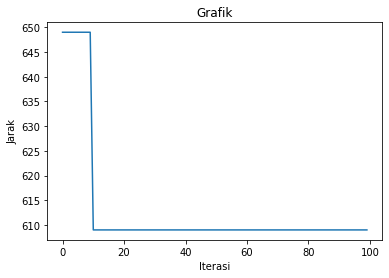

In [27]:
plt.title('Grafik')
plt.plot(best[:100])
plt.xlabel('Iterasi')
plt.ylabel('Jarak')